### This notebook takes the prepared data and carries out the selected modelling techniques.

### In this notebook, the fake data will be used in the model to show that it is running properly. Please note that the results are irrelevant here since the data is completely fake.

In [23]:
# path_to_src = # Replace to your path
# import sys; sys.path += [path_to_src]

import pandas as pd
import matplotlib.pyplot as plt
from models.tree_forest import train_random_forest_model, train_decision_tree_model, loop_random_forest_model, loop_decision_tree_model
from visualisation.__init__ import make_feature_importance_table, make_handover_times_results_table, make_handover_delay_results_table

### Getting the fake data for `3`, `10`, and `24` hours:

In [35]:
fake_data_3_hour = pd.read_parquet("../outputs/data_for_three_hour_pred.parquet")
fake_data_10_hour = pd.read_parquet("../outputs/data_for_ten_hour_pred.parquet")
fake_data_24_hour = pd.read_parquet("../outputs/data_for_twenty_four_hour_pred.parquet")

### The columns of the fake datasets are such that they replicate those in the true data:

- Time
- Hospital name
- No. of A skills that are missing from ambulance arrivals in the last 6 hours
- No. of B skills that are missing from ambulance arrivals in the last 6 hours
- No. of C skills that are missing from ambulance arrivals in the last 6 hours
- No. of D skills that are missing from ambulance arrivals in the last 6 hours
- No. of E skills that are missing from ambulance arrivals in the last 6 hours
- No. of ambulance arriving in the last 6 hours
- No. of ambulance depatures in the last 6 hours
- Proxy for net flow (admissions, discharges, transfers)
- The average time of past delays (minutes) in the last 6 hours per hospital
- The weighted sum by distance of the number of ambulances arriving at other hospitals
- No. of people arriving in the last 6 hours that are aged less than 1
- No. of people arriving in the last 6 hours that are aged between 1 and 18
- No. of people arriving in the last 6 hours that are aged between 19 and 36
- No. of people arriving in the last 6 hours that are aged between 37 and 54
- No. of people arriving in the last 6 hours that are aged between 55 and 72
- No. of people arriving in the last 6 hours that are aged between 73 and 90
- No. of people arriving in the last 6 hours that are aged above 90
- No. of people arriving in the last 6 hours that are responding priority 1
- No. of people arriving in the last 6 hours that are responding priority 2
- No. of people arriving in the last 6 hours that are responding priority 3
- No. of people arriving in the last 6 hours that are responding priority 4
- No. of people arriving in the last 6 hours that are responding priority 5
- No. of people arriving in the last 6 hours that are responding priority 6
- No. of people arriving in the last 6 hours that are responding priority 7
- No. of people arriving in the last 6 hours that are responding priority 8
- No. of people arriving in the last 6 hours that are responding priority 9
- No. of ambulances arriving in the last 6 hour that have transported 1 patient
- No. of ambulances arriving in the last 6 hour that have transported 2 patient
- No. of ambulances arriving in the last 6 hour that have transported 3 patient
- Day of week
- Month
- Hour of day
- Bank holiday
- Max temperature 
- Min temperature
- Rainfall (mm)

### Make a `dict` with the hours and their corresponding fake datasets:

In [36]:
fake_datasets_dict = {'3': fake_data_3_hour,
                      '10': fake_data_10_hour,
                      '24': fake_data_24_hour}

### Initialising the list of fake hospitals:

In [37]:
list_of_fake_hospitals = ['hospital_A', 
                          'hospital_B',
                          'hospital_C',
                          'hospital_D',
                          'hospital_E']

### Initialising the `FAKE_ORDINALS` and `FAKE_REALS`:

In [38]:
TARGET = ['handover_delay_mins']

FAKE_ORDINALS = {'day_of_week': ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
                 'month': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                 'hour_of_day': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
                 'bank_holiday': ['No', 'Yes']}

FAKE_REALS = ['missing_skill_A', 'missing_skill_B', 'missing_skill_C', 'missing_skill_D', 'missing_skill_E', 
              'num_ambulance_arrivals', 'num_ambulance_departures',
              'flow', 
              'past_delay_mins', 
              'weighted_arrivals_other', 
              '1 to 18', '19 to 36', '37 to 54', '55 to 72', '73 to 90', '90+', '<1', 
              'priority_1', 'priority_2', 'priority_3', 'priority_4', 'priority_5', 'priority_6', 'priority_7', 'priority_8', 'priority_9', 
              '1_patient_transported', '2_patients_transported', '3_patients_transported', 
              'tmax', 'tmin', 'rain']

___

## Decision Tree model:

### Run the Decision Tree model using the fake data, fake ordinals, and fake reals:

The loop_decision_tree_model from modelling.py carries out the following:
- Creates a model per hospital to predict the handover delay at the hospital in 3, 10 and 24 hours time
- Calculates the decrease in impurity at each split to see the key drivers to the prediction 

Hospital: hospital_A, Hour: 3, Starting modelling...


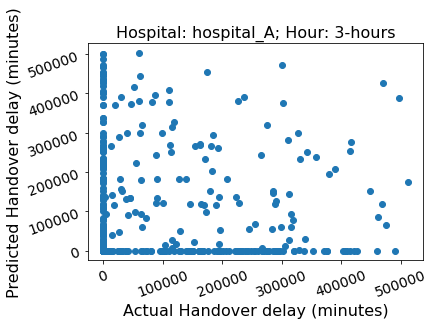

Hospital: hospital_A, Hour: 3, Getting important features...

Hospital: hospital_A, Hour: 10, Starting modelling...


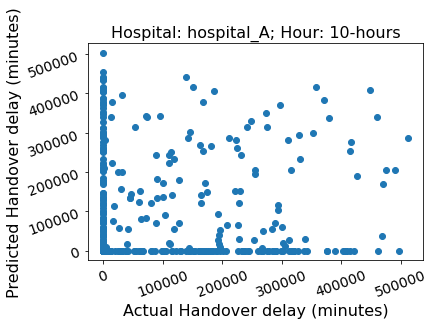

Hospital: hospital_A, Hour: 10, Getting important features...

Hospital: hospital_A, Hour: 24, Starting modelling...


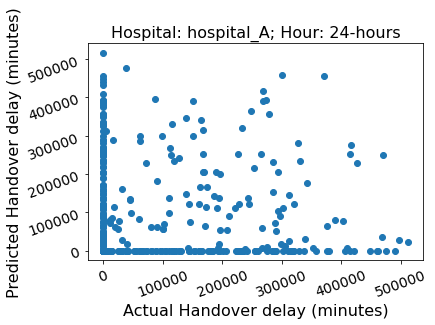

Hospital: hospital_A, Hour: 24, Getting important features...

Hospital: hospital_B, Hour: 3, Starting modelling...


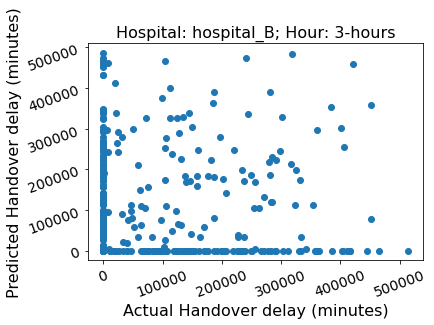

Hospital: hospital_B, Hour: 3, Getting important features...

Hospital: hospital_B, Hour: 10, Starting modelling...


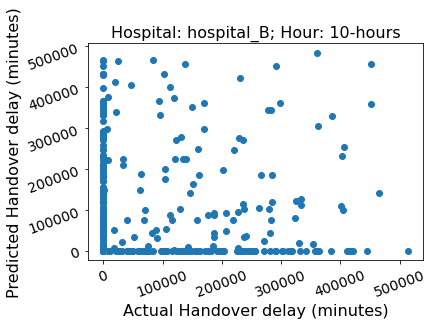

Hospital: hospital_B, Hour: 10, Getting important features...

Hospital: hospital_B, Hour: 24, Starting modelling...


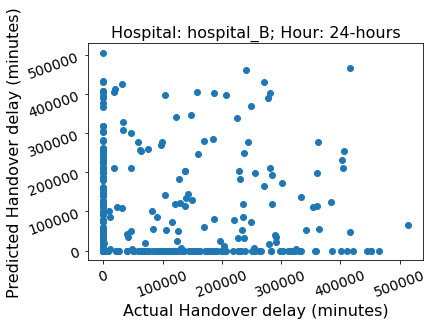

Hospital: hospital_B, Hour: 24, Getting important features...

Hospital: hospital_C, Hour: 3, Starting modelling...


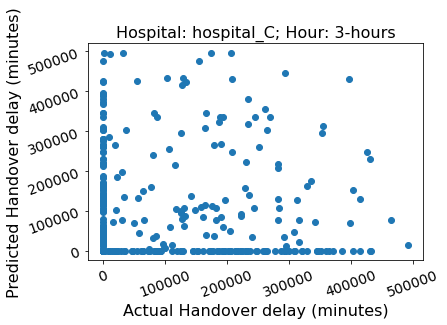

Hospital: hospital_C, Hour: 3, Getting important features...

Hospital: hospital_C, Hour: 10, Starting modelling...


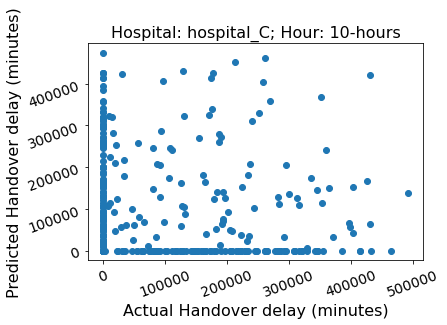

Hospital: hospital_C, Hour: 10, Getting important features...

Hospital: hospital_C, Hour: 24, Starting modelling...


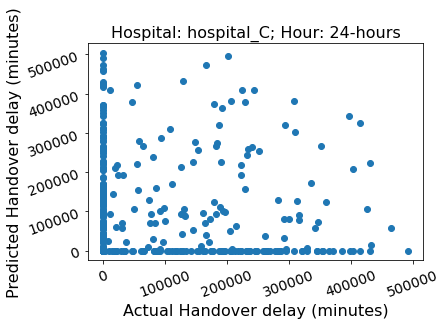

Hospital: hospital_C, Hour: 24, Getting important features...

Hospital: hospital_D, Hour: 3, Starting modelling...


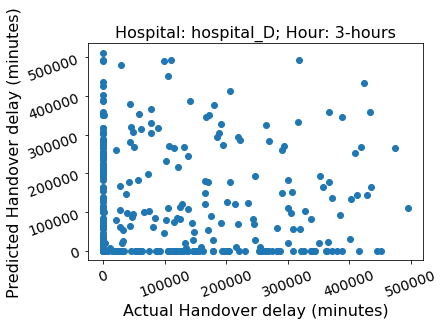

Hospital: hospital_D, Hour: 3, Getting important features...

Hospital: hospital_D, Hour: 10, Starting modelling...


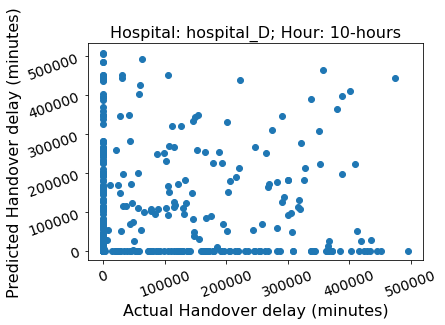

Hospital: hospital_D, Hour: 10, Getting important features...

Hospital: hospital_D, Hour: 24, Starting modelling...


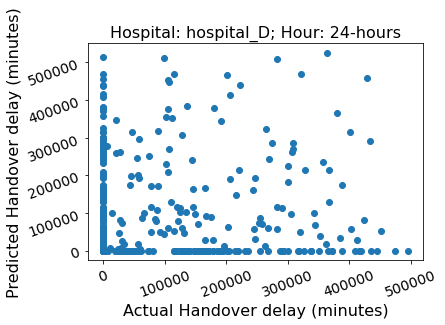

Hospital: hospital_D, Hour: 24, Getting important features...

Hospital: hospital_E, Hour: 3, Starting modelling...


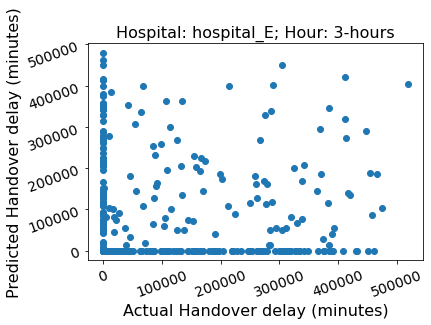

Hospital: hospital_E, Hour: 3, Getting important features...

Hospital: hospital_E, Hour: 10, Starting modelling...


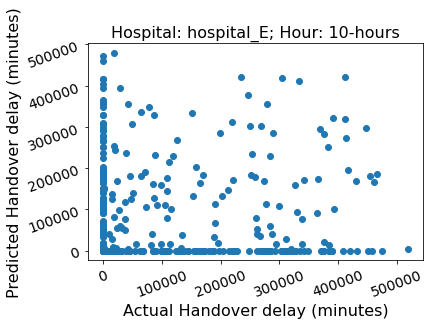

Hospital: hospital_E, Hour: 10, Getting important features...

Hospital: hospital_E, Hour: 24, Starting modelling...


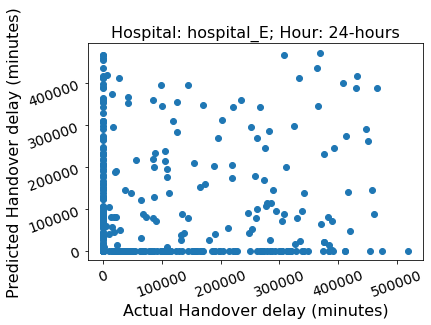

Hospital: hospital_E, Hour: 24, Getting important features...



In [39]:
decision_tree_fake_results_df, decision_tree_fake_results_dict = loop_decision_tree_model(FAKE_ORDINALS, FAKE_REALS, fake_datasets_dict, list_of_fake_hospitals, feature_importance=True)

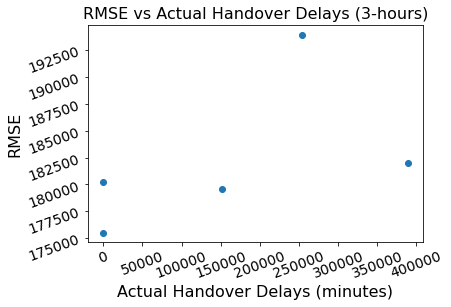

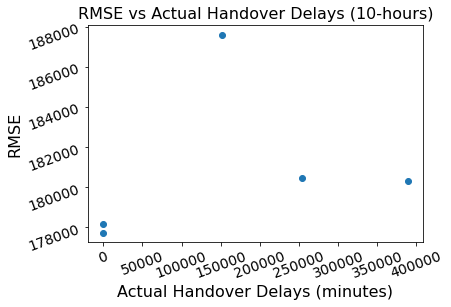

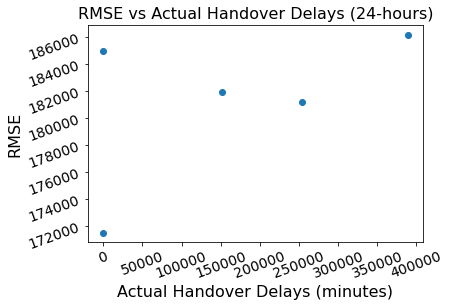

In [40]:
fontsize = 16

x_var = decision_tree_fake_results_dict['actual']

y_var_3 = decision_tree_fake_results_df['root_mean_squared_error_3'].values
y_var_10 = decision_tree_fake_results_df['root_mean_squared_error_10'].values
y_var_24 = decision_tree_fake_results_df['root_mean_squared_error_24'].values

rmse_dict = {"3": y_var_3,
             "10": y_var_10,
             "24": y_var_24}


for hour, y_var in rmse_dict.items():
    plt.scatter(x_var, y_var)

    plt.xlabel('Actual Handover Delays (minutes)', fontsize=fontsize)
    plt.ylabel('RMSE', fontsize=fontsize)

    plt.xticks(fontsize=fontsize-2, rotation=20)
    plt.yticks(fontsize=fontsize-2, rotation=20)

    plt.title(f"RMSE vs Actual Handover Delays ({hour}-hours)", fontsize=fontsize)

    plt.show()

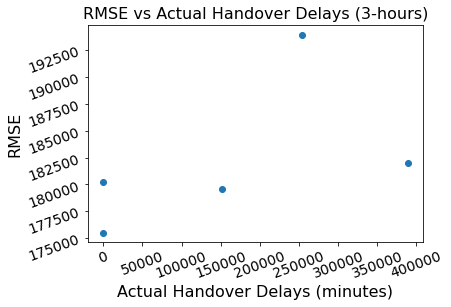

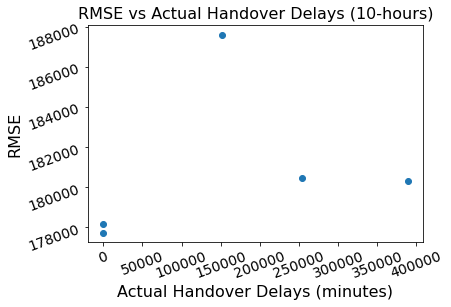

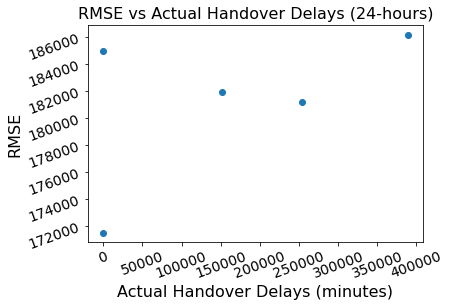

In [41]:
fontsize = 16

x_var = decision_tree_fake_results_dict['actual']

y_var_3 = decision_tree_fake_results_df['root_mean_squared_error_3'].values
y_var_10 = decision_tree_fake_results_df['root_mean_squared_error_10'].values
y_var_24 = decision_tree_fake_results_df['root_mean_squared_error_24'].values

rmse_dict = {"3": y_var_3,
             "10": y_var_10,
             "24": y_var_24}


for hour, y_var in rmse_dict.items():
    plt.scatter(x_var, y_var)

    plt.xlabel('Actual Handover Delays (minutes)', fontsize=fontsize)
    plt.ylabel('RMSE', fontsize=fontsize)

    plt.xticks(fontsize=fontsize-2, rotation=20)
    plt.yticks(fontsize=fontsize-2, rotation=20)

    plt.title(f"RMSE vs Actual Handover Delays ({hour}-hours)", fontsize=fontsize)

    plt.show()

### Getting the results table for the Decision Tree model:

In [42]:
fake_decision_tree_results_table = make_handover_times_results_table(decision_tree_fake_results_df, coloured_output=True, highlight_by='mean')
fake_decision_tree_results_table

,Handover Time Range for 3hr (minutes),Handover Time Range for 10hr (minutes),Handover Time Range for 24hr (minutes)
Hospital,,,
hospital_A,0 - 139935,78369 - 331925,0 - 126458
hospital_B,82485 - 337850,66567 - 316827,89822 - 330513
hospital_C,178157 - 427004,0 - 200056,0 - 133402
hospital_D,0 - 128314,127192 - 391743,0 - 129277
hospital_E,0 - 128887,0 - 128102,0 - 204175


### Getting the feature importance table for the Decision Tree model:

In [43]:
keyword_to_english_map = {'hospital': 'Hospital',
                          'day_of_week': 'Day of Week',
                          'month': 'Month',
                          'hour_of_day': 'Hour of the Day',
                          'bank_holiday': 'Bank Holiday',
                          'missing_skill_A': 'Missing Crew Skill',
                          'missing_skill_B': 'Missing Crew Skill',
                          'missing_skill_C': 'Missing Crew Skill',
                          'missing_skill_D': 'Missing Crew Skill',
                          'missing_skill_E': 'Missing Crew Skill',
                          'num_ambulance_arrivals': 'Number of Ambulance Arrivals',
                          'num_ambulance_departures': 'Number of Ambulance Departures',
                          'flow': 'Patient Flow',  
                          'past_delay_mins': 'Average Handover Delay in Past 6 Hours',
                          'weighted_arrivals_other': 'Arrivals at Hospitals Nearby',
                          '1 to 18': "Number of 1 to 18 Year Old's Arriving",
                          '19 to 36': "Number of 19 to 36 Year Old's Arriving",
                          '37 to 54': "Number of 37 to 54 Year Old's Arriving",
                          '55 to 72': "Number of 55 to 72 Year Old's Arriving",
                          '73 to 90': "Number of 73 to 90 Year Old's Arriving",
                          '90+': "Number of 90+ Year Old's Arriving",
                          '<1': "Number of <1 Year Old's Arriving",
                          'priority_1': 'Number of Priority 1 Cases',
                          'priority_2': 'Number of Priority 2 Cases',
                          'priority_3': 'Number of Priority 3 Cases',
                          'priority_4': 'Number of Priority 4 Cases',
                          'priority_5': 'Number of Priority 5 Cases',
                          'priority_6': 'Number of Priority 6 Cases',
                          'priority_7': 'Number of Priority 7 Cases',
                          'priority_8': 'Number of Priority 8 Cases',
                          'priority_9': 'Number of Priority 9 Cases',
                          '1_patient_transported': 'Number of 1-patient Ambulances',
                          '2_patients_transported': 'Number of 2-patients Ambulances',
                          '3_patients_transported': 'Number of 3-patients Ambulances',
                          'tmax': 'Maximum Temperature',
                          'tmin': 'Minimum Temperature',
                          'rain': 'Rainfall'}

The importance table is created using the fake decision tree feature importance table function and it summarises the three top features for each prediction for each hospital. This example is using the latest timestamp in our data. The table is showing what the model would have predicted from the situation at the hospital 3 hours ago, 10 hours ago and 24 hours ago. 

In [44]:
fake_decision_tree_feature_importance_table = make_feature_importance_table(decision_tree_fake_results_dict, list_of_fake_hospitals, keyword_to_english_map)

fake_decision_tree_feature_importance_table

3hr-Prediction  \
Hospital   Feature Number                                           
hospital_A 1                                             Rainfall   
           2               Number of 55 to 72 Year Old's Arriving   
           3                       Number of Ambulance Departures   
hospital_B 1                           Number of Priority 9 Cases   
           2                           Number of Priority 2 Cases   
           3                                   Missing Crew Skill   
hospital_C 1                         Arrivals at Hospitals Nearby   
           2                           Number of Priority 4 Cases   
           3                                      Hour of the Day   
hospital_D 1                         Arrivals at Hospitals Nearby   
           2                                  Minimum Temperature   
           3                                      Hour of the Day   
hospital_E 1                                          Day of Week   
           2                                      Hour of the Day   
           3                         Arrivals at Hospitals Nearby   

                                                  10hr-Prediction  \
Hospital   Feature Number                                           
hospital_A 1                                   Missing Crew Skill   
           2                         Arrivals at Hospitals Nearby   
           3                                   Missing Crew Skill   
hospital_B 1                                         Patient Flow   
           2                         Arrivals at Hospitals Nearby   
           3                                             Rainfall   
hospital_C 1                                      Hour of the Day   
           2               Average Handover Delay in Past 6 Hours   
           3                                   Missing Crew Skill   
hospital_D 1                                      Hour of the Day   
           2               Number of 73 to 90 Year Old's Arriving   
           3                           Number of Priority 4 Cases   
hospital_E 1               Average Handover Delay in Past 6 Hours   
           2                                          Day of Week   
           3                           Number of Priority 2 Cases   

                                                  24hr-Prediction  
Hospital   Feature Number                                          
hospital_A 1                         Arrivals at Hospitals Nearby  
           2                                   Missing Crew Skill  
           3                      Number of 2-patients Ambulances  
hospital_B 1               Average Handover Delay in Past 6 Hours  
           2                         Arrivals at Hospitals Nearby  
           3                                             Rainfall  
hospital_C 1                                  Maximum Temperature  
           2                                   Missing Crew Skill  
           3               Average Handover Delay in Past 6 Hours  
hospital_D 1                                         Patient Flow  
           2                                      Hour of the Day  
           3                                   Missing Crew Skill  
hospital_E 1               Average Handover Delay in Past 6 Hours  
           2                         Arrivals at Hospitals Nearby  
           3                       Number of Ambulance Departures

___

## Random Forest model:

### Run the Random Forest model using the fake data, fake ordinals, and fake reals:

Hospital: hospital_A, Hour: 3, Starting modelling...


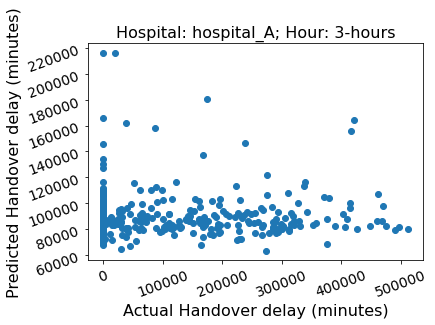

Hospital: hospital_A, Hour: 3, Getting important features...

Hospital: hospital_A, Hour: 10, Starting modelling...


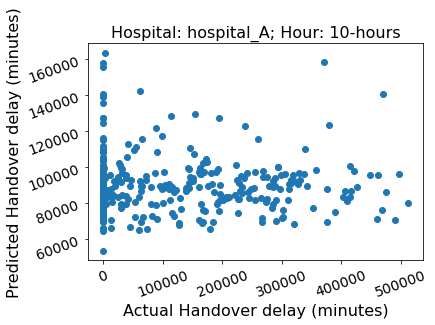

Hospital: hospital_A, Hour: 10, Getting important features...

Hospital: hospital_A, Hour: 24, Starting modelling...


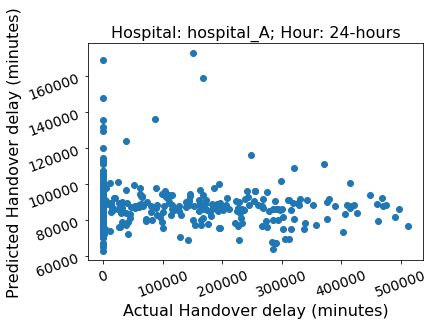

Hospital: hospital_A, Hour: 24, Getting important features...

Hospital: hospital_B, Hour: 3, Starting modelling...


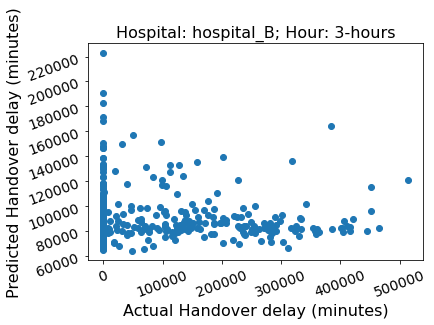

Hospital: hospital_B, Hour: 3, Getting important features...

Hospital: hospital_B, Hour: 10, Starting modelling...


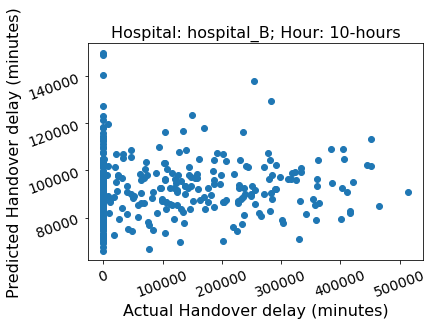

Hospital: hospital_B, Hour: 10, Getting important features...

Hospital: hospital_B, Hour: 24, Starting modelling...


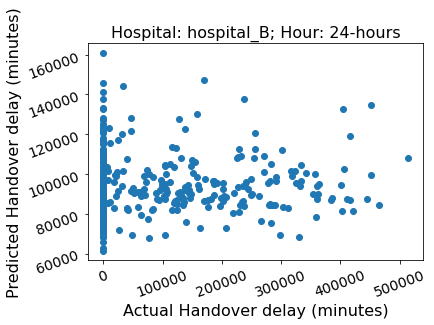

Hospital: hospital_B, Hour: 24, Getting important features...

Hospital: hospital_C, Hour: 3, Starting modelling...


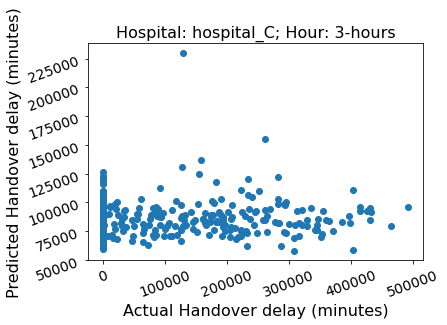

Hospital: hospital_C, Hour: 3, Getting important features...

Hospital: hospital_C, Hour: 10, Starting modelling...


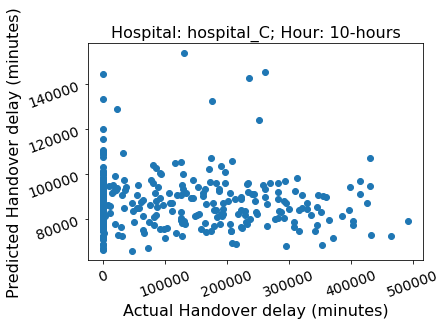

Hospital: hospital_C, Hour: 10, Getting important features...

Hospital: hospital_C, Hour: 24, Starting modelling...


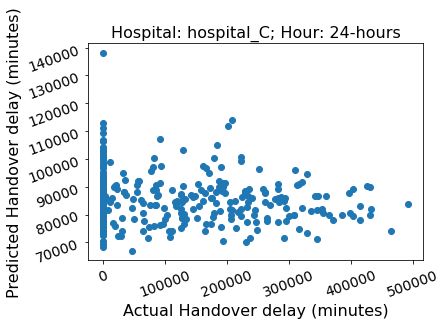

Hospital: hospital_C, Hour: 24, Getting important features...

Hospital: hospital_D, Hour: 3, Starting modelling...


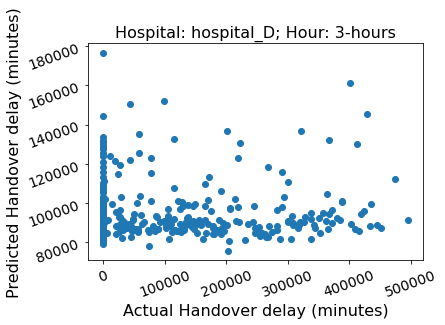

Hospital: hospital_D, Hour: 3, Getting important features...

Hospital: hospital_D, Hour: 10, Starting modelling...


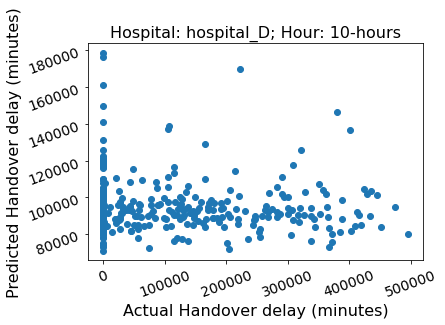

Hospital: hospital_D, Hour: 10, Getting important features...

Hospital: hospital_D, Hour: 24, Starting modelling...


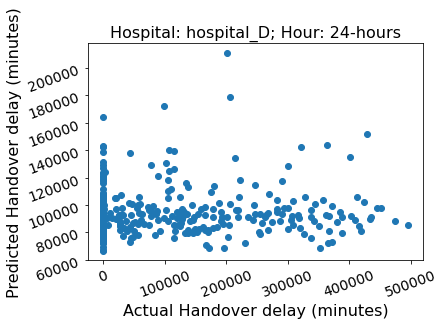

Hospital: hospital_D, Hour: 24, Getting important features...

Hospital: hospital_E, Hour: 3, Starting modelling...


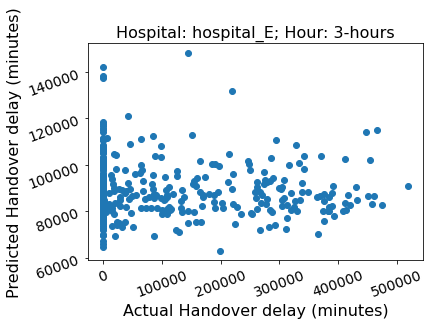

Hospital: hospital_E, Hour: 3, Getting important features...

Hospital: hospital_E, Hour: 10, Starting modelling...


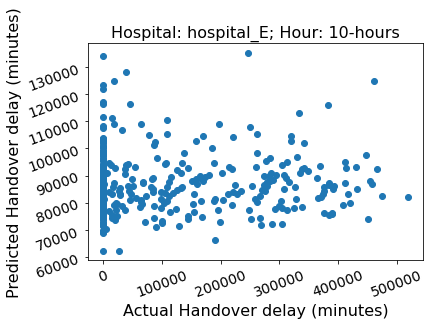

Hospital: hospital_E, Hour: 10, Getting important features...

Hospital: hospital_E, Hour: 24, Starting modelling...


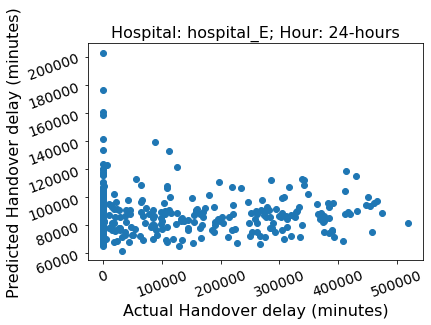

Hospital: hospital_E, Hour: 24, Getting important features...



In [45]:
random_forest_fake_results_df, random_forest_fake_results_dict = loop_random_forest_model(FAKE_ORDINALS, FAKE_REALS, fake_datasets_dict, list_of_fake_hospitals, feature_importance=True)

### Getting the results table for the Random Forest model:

In [48]:
fake_random_forest_results_table = make_handover_times_results_table(random_forest_fake_results_df, coloured_output=False)
df_results = fake_random_forest_results_table
df_results.to_csv('../outputs/random_forest_results_table.csv')

### Getting the feature importance table for the Random Forest model:

In [47]:
fake_random_forest_feature_importance_table = make_feature_importance_table(random_forest_fake_results_dict, list_of_fake_hospitals, keyword_to_english_map)
df_feature_results = fake_random_forest_feature_importance_table
df_feature_results.to_csv('../outputs/random_forest_feature_importance_table.csv')

3hr-Prediction  \
Hospital   Feature Number                                           
hospital_A 1                                             Rainfall   
           2               Number of 55 to 72 Year Old's Arriving   
           3                           Number of Priority 3 Cases   
hospital_B 1                           Number of Priority 2 Cases   
           2                           Number of Priority 9 Cases   
           3                                   Missing Crew Skill   
hospital_C 1                         Arrivals at Hospitals Nearby   
           2                                  Maximum Temperature   
           3                      Number of 3-patients Ambulances   
hospital_D 1                         Arrivals at Hospitals Nearby   
           2                                      Hour of the Day   
           3               Number of 73 to 90 Year Old's Arriving   
hospital_E 1                                          Day of Week   
           2                         Arrivals at Hospitals Nearby   
           3                                             Rainfall   

                                                  10hr-Prediction  \
Hospital   Feature Number                                           
hospital_A 1                                             Rainfall   
           2                                   Missing Crew Skill   
           3                         Arrivals at Hospitals Nearby   
hospital_B 1                         Arrivals at Hospitals Nearby   
           2                                         Patient Flow   
           3                                                Month   
hospital_C 1                                  Maximum Temperature   
           2               Average Handover Delay in Past 6 Hours   
           3                           Number of Priority 7 Cases   
hospital_D 1                                      Hour of the Day   
           2               Number of 73 to 90 Year Old's Arriving   
           3                                          Day of Week   
hospital_E 1               Average Handover Delay in Past 6 Hours   
           2                                          Day of Week   
           3                           Number of Priority 2 Cases   

                                                  24hr-Prediction  
Hospital   Feature Number                                          
hospital_A 1                                             Rainfall  
           2                         Arrivals at Hospitals Nearby  
           3                                   Missing Crew Skill  
hospital_B 1               Average Handover Delay in Past 6 Hours  
           2                         Arrivals at Hospitals Nearby  
           3                      Number of 3-patients Ambulances  
hospital_C 1               Average Handover Delay in Past 6 Hours  
           2                         Arrivals at Hospitals Nearby  
           3                       Number of Ambulance Departures  
hospital_D 1                                      Hour of the Day  
           2                       Number of Ambulance Departures  
           3                         Arrivals at Hospitals Nearby  
hospital_E 1               Average Handover Delay in Past 6 Hours  
           2                         Arrivals at Hospitals Nearby  
           3                                          Day of Week